# Airfare Price Prediction Project - Data Science

It is important for a traveller to know the fare value of a trip, and as prices of flight ticket change very often it becomes hard for a user to check different websites, and to find different deals. A flight fare prediction model will help inform the travellers when the optimal time to buy their flight tickets, and it will help us understand trends in the airline industry.

The route from New York's JFK airport to London's Heathrow airport(LHR) is one of the busiest air routes in the world. I decided to try and help out the passengers who take this route, by trying to figure out what causes the prices to be higher or lower, who is more likely to offer better flight, and to create a model that'll be able to predict the price given the appropriate information of a certain flight.

## Data Collection - First Attempt
At first, I had in mind to try and create a model that'll tell the traveller when the prices will be lowest for the route based on previous infromation. Though after searching and scanning the internet I came up with no such data, as the airlines do not publicize this information willingly, and any other companies that offer the service, do not do it free of charge. The only other dataset that seemed to give airfares and information about past flights was from the US Bureau of Transportation Statistics, but it had information on domestic flights only, so it too did not offer anything about the JFK-LHR route.
After understanding that I'll have to get the information by myself, I started recording flight information and their prices using Amadeus's API, (https://developers.amadeus.com/). I wrote a script to get the information and I ran it once a day for a week.

### Data Analizing

The features that I collected for each flight are as followes:
* Airline - the airline carrier of the flight               
* IDs - the IDs of the flight legs
* Date_of_Journey - the date of departure
* Route  - the airport codes for the route
* Dep_Time - the departure time from JFK
* Arrival_Time - the arrival time at LHR
* Duration - the total duration of the flights, including layovers
* Total_Stops - total stops in the journey
* One_Way - is it a round trip or one way ticket
* Last_Ticketing_Date - the last available date for buying the tickets
* Cabins - the ticket's cabin, such as economy and business (or cabins if there's more than one leg)
* Classes - the airline fare class code, for each leg
* Checked_Bags_Included - the number of checked bags allowed 
* Price - the price of the ticket (target feature)
* Date_Taken - the date the information was recorded

In [1]:
import sys; print(sys.version)
import pandas as pd; print (pd.__version__ )
import seaborn as sns; print (sns.__version__)
import matplotlib.pyplot as plt; 
import numpy as np
from sklearn import neighbors, datasets

3.7.6 (default, Jan  8 2020, 20:23:39) [MSC v.1916 64 bit (AMD64)]
1.0.1
0.10.0


In [2]:
# we'll load all the data into dataframe and merge them one with the other to get one large data frame. 
df_flights = pd.read_csv('Airfare1.csv')
filename = 'Airfare'
ending = '.csv'
for i in np.linspace(2,7,6):
    df_flights = df_flights.append(pd.read_csv(filename+str(int(i))+ending))

df_flights.head()

,Airline,IDs,Date_of_Journey,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,One_Way,Last_Ticketing_Date,Cabins,Classes,Checked_Bags_Included,Price,Date_Taken
0,AEROFLOT,"181,182",2020-09-24,JFK→SVO→LHR,2020-09-24T14:15:00,2020-09-25T09:50:00,PT14H35M,1,False,2020-09-24,"ECONOMY,ECONOMY","R,R",1,340.87,2020-09-24
1,AEROFLOT,"189,190",2020-09-24,JFK→SVO→LHR,2020-09-24T00:55:00,2020-09-25T09:30:00,PT27H35M,1,False,2020-09-24,"ECONOMY,ECONOMY","R,R",1,340.87,2020-09-24
2,AEROFLOT,"264,265",2020-09-24,JFK→SVO→LHR,2020-09-24T00:55:00,2020-09-25T09:50:00,PT27H55M,1,False,2020-09-24,"ECONOMY,ECONOMY","R,R",1,340.87,2020-09-24
3,AEROFLOT,"171,172",2020-09-24,JFK→SVO→LHR,2020-09-24T00:55:00,2020-09-24T21:25:00,PT15H30M,1,False,2020-09-24,"ECONOMY,ECONOMY","R,R",1,340.87,2020-09-24
4,AEROFLOT,"199,200",2020-09-24,JFK→SVO→LHR,2020-09-24T19:20:00,2020-09-25T16:00:00,PT15H40M,1,False,2020-09-24,"ECONOMY,ECONOMY","R,R",1,340.87,2020-09-24


Lets see how many stops these flights have:

Text(0, 0.5, 'Count of flights')

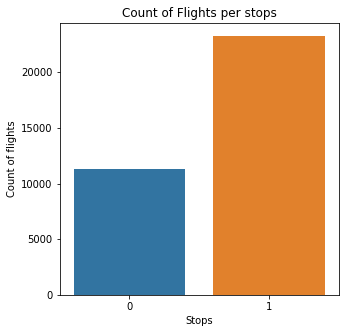

In [3]:
plt.figure(figsize = (5 , 5))
plt.title('Count of Flights per stops')
sns.countplot(x = 'Total_Stops', data = df_flights)
plt.xlabel('Stops')
plt.ylabel('Count of flights')

Let's also see how many of the flights aren't round trips rather only one way tickets 

In [4]:
print('number of one way tickets:',len(df_flights.where(df_flights['One_Way']==True).dropna()))

number of one way tickets: 0


So the majority of the flights have one stop, but there are also a lot of non-stop flights.
Also every single one of these flights is part of a round trip

One of the most important features of a flight is its duration and it's given to us in ISO 8601 format(https://en.wikipedia.org/wiki/ISO_8601) and it'll be more useful to work with a single number, so we'll convert the hours to minutes and change the column to be in minutes only.

In [5]:
def convert_dur_to_mins(dur):
    dur = dur[2:] # get rid of 'PT'
    ind_h,ind_m = dur.find('H'),dur.find('M')
    hours = dur[:ind_h]
    if hours!='':
        hours = int(hours)
    else:
        hours = 0 
        
    mins = dur[ind_h+1:ind_m]
    if mins!='':
        mins = int(mins)
    else:
        mins = 0 
    tot = 60*hours+mins
    return tot

df_flights['Duration'] = pd.Series([convert_dur_to_mins(dur) for dur in df_flights['Duration']])


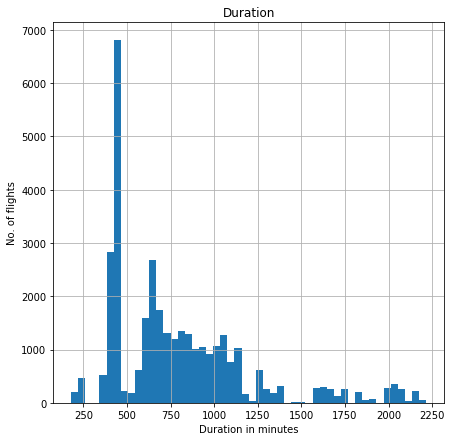

In [6]:
%matplotlib inline 
df_flights.hist(bins=50,column='Duration', figsize=(7,7))
plt.xlabel('Duration in minutes')
plt.ylabel('No. of flights')
plt.show()

it seems that there are a lot of flights that are less than 250 minutes long. They cross the atlantic ocean in less than 5 hours. Seems a bit strange as the normal non-stop flight from JFK to LHR is approximatly 7hours =  420 minutes, and the shortest 1 stop flight seems to be 530 minutes. 

In [7]:
non_stop_flights = df_flights.where(df_flights['Total_Stops']==0).dropna()
strange_flights = non_stop_flights.where(non_stop_flights['Duration']<410).dropna()
one_stop_flights = df_flights.where(df_flights['Total_Stops']==1).dropna()
strange_flights = strange_flights.append(non_stop_flights.where(non_stop_flights['Duration']<530).dropna())
print('count strange flights:',len(strange_flights))
print('count all flights:', len(df_flights))
print('percentage of strange flights:',round(len(strange_flights)/len(df_flights)*100,2),'%')

count strange flights: 5999
count all flights: 34542
percentage of strange flights: 17.37 %


This is really quite scary... 
If more than 17% of the flights have bad information about the duration, I'm afraid that the data provided by Amadeus is inaccurate about the other features as well, including the prices.

I came to the conclusion that this is not a good approach for the problem for the following reasons: 

* A lot of the data provided by Amadeus is bad. I even tried to find some of the flights on booking sites and found the departure times were also wrong. This made me think that other features might be inaccurate which could change the entire model.

* All the flights seem to be part of a round trip and the price shown is for the whole trip, but none of the inbound flight information is provided, and that could be just as critical for the price prediction as is the information of the outbound flight.

* The amount of data that I can collect in such little time would not represent the fluctuations of a ticket price properly. I would have needed a few months worth of data to get the real picture.

## Data Collection - Second Attempt
I understood that Amadeus's API was not the way to go, so I went to skyscanner, and it took me a while to get an API key, but in the end I got my hands on one. So using Skyscanner's API(https://skyscanner.github.io/slate/), I wrote a script to collect flight information for tickets from JFK to LHR, for 1 adult, economy class, with a round trip returning after 7 days. I then wrote a script to take the important information that might have some effect on the price, such as airline, duration, departue and arrival time, and put it all in a csv file. I left out some information that has nothing to do with the price, such as the logo's of the different airlines and what the symbol of the dollar is.

I ran the script for the the months of October-December 2020 (93 days in total, as i included  January 1st as well) collecting 106,667 different fares and their appropriate trips,
and we'll see what this data gives us.

### Data Analizing and Preperation

The features that I collected from skyscanner for each flight are as followes:
* Out_Airline - airline carrier of the outbound flight
* Out_Departure - departure date and time of the outbound flight 
* Out_Arrival - arrival date and time of the outbound flight  
* Out_Duration - outbound flight duration (in minutes) 
* Out_Route - the route of the outbound flight
* In_Airline - airline carrier of the inbound flight
* In_Departure -  departure date and time of the inbound flight
* In_Arrival - arrival date and time of the inbound flight 
* In_Duration -inbound flight duration (in minutes)
* In_Route - the route of the inbound flight
* Out_ID - the id skyscanner gave to the outbound flight 
* In_ID - the id skyscanner gave to the inbound flight
* Buying_Url - link for booking the ticket
* Price - the total ticket fare in dollars

In [8]:
df_flights = pd.read_csv('AirFare_Skyscanner.csv')
df_flights.head()

,Out_Airline,Out_Departure,Out_Arrival,Out_Duration,Out_Route,In_Airline,In_Departure,In_Arrival,In_Duration,In_Route,Out_ID,In_ID,Buying_Url,Price
0,British Airways,2020-10-01T21:30:00,2020-10-02T09:35:00,425,JFK→LHR,Virgin Atlantic,2020-10-08T20:15:00,2020-10-08T23:10:00,475,LHR→JFK,12712-2010012130--32222-0-13554-2010020935,13554-2010082015--32132-0-12712-2010082310,https://partners.api.skyscanner.net/apiservice...,1443.20
1,Air France,2020-10-01T19:30:00,2020-10-02T10:40:00,610,JFK→CDG→LHR,Delta,2020-10-08T10:20:00,2020-10-08T13:30:00,490,LHR→JFK,12712-2010011930--32677-1-13554-2010021040,13554-2010081020--32132-0-12712-2010081330,https://partners.api.skyscanner.net/apiservice...,1248.80
2,British Airways,2020-10-01T18:10:00,2020-10-02T06:10:00,420,JFK→LHR,British Airways,2020-10-08T09:30:00,2020-10-08T16:00:00,690,LHR→DUB→JFK,12712-2010011810--32480-0-13554-2010020610,13554-2010080930--32480-1-12712-2010081600,https://partners.api.skyscanner.net/apiservice...,1337.17
3,Delta,2020-10-01T08:30:00,2020-10-02T08:25:00,1135,JFK→ATL→LHR,Delta,2020-10-08T10:20:00,2020-10-08T13:30:00,490,LHR→JFK,12712-2010010830--31697-1-13554-2010020825,13554-2010081020--31697-0-12712-2010081330,https://partners.api.skyscanner.net/apiservice...,1234.25
4,British Airways,2020-10-01T21:30:00,2020-10-02T09:35:00,425,JFK→LHR,British Airways,2020-10-08T10:45:00,2020-10-08T13:35:00,470,LHR→JFK,12712-2010012130--32317-0-13554-2010020935,13554-2010081045--32222-0-12712-2010081335,https://partners.api.skyscanner.net/apiservice...,1281.00


#### Check for missing values or duplicates 

In [9]:
duplicate_rows = df_flights[df_flights.duplicated()]
print("Total duplicate rows except first occurrence based on all columns are :",len(duplicate_rows))


Total duplicate rows except first occurrence based on all columns are : 0


In [10]:
df_flights.isnull().sum()

Out_Airline      0
Out_Departure    0
Out_Arrival      0
Out_Duration     0
Out_Route        0
In_Airline       0
In_Departure     0
In_Arrival       0
In_Duration      0
In_Route         0
Out_ID           0
In_ID            0
Buying_Url       0
Price            0
dtype: int64

In [11]:
df_flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106667 entries, 0 to 106666
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Out_Airline    106667 non-null  object 
 1   Out_Departure  106667 non-null  object 
 2   Out_Arrival    106667 non-null  object 
 3   Out_Duration   106667 non-null  int64  
 4   Out_Route      106667 non-null  object 
 5   In_Airline     106667 non-null  object 
 6   In_Departure   106667 non-null  object 
 7   In_Arrival     106667 non-null  object 
 8   In_Duration    106667 non-null  int64  
 9   In_Route       106667 non-null  object 
 10  Out_ID         106667 non-null  object 
 11  In_ID          106667 non-null  object 
 12  Buying_Url     106667 non-null  object 
 13  Price          106667 non-null  float64
dtypes: float64(1), int64(2), object(11)
memory usage: 11.4+ MB


#### Creating the Test Set  

Since we're interested in creating a good model, we'll have to see if it really is  is good by testing it on different data. Therefore we'll create a test set by setting aside 20% of the data from our dataframe
It's good to have a stable train/test split even after the dataset gets updated (if I end up updating it in the future), so I'll be using the instance’s identifier to decide whether or not it should go in the test set.
Updates therefore need to be appended to the end(!) of the dataset.

In [12]:
#  we'll compute a hash of each instance’s identifier and put that instance in the test set if the
# hash is lower than or equal to 20% of the maximum hash value
from zlib import crc32
def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32
def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

 # adds an `index` column
fares_with_id = df_flights.reset_index()
train_set, test_set = split_train_test_by_id(fares_with_id, 0.2, "index")

print('training set length:', len(train_set), '\ntest set length: ',len(test_set))

training set length: 85333 
test set length:  21334


#### Feature extraction 

We'd prefer having features that'll help us, so I'll use the dates to find out about which month and day the flight takes place, and whether it was on a weekend and which day of the week it's on, as these could definitly help us figure out what the price is.
Also we'll categorize the times to be morning, afternoon, evening, or night flight.


In [13]:
def departtime(x):
    tt=(int)(x.split(':')[0])
    if(tt >= 16 and tt < 21):
        x='Evening'
    elif(tt >= 21 or tt < 5):
        x='Night'
    elif(tt >= 5 and tt < 11):
        x='Morning'
    elif(tt >= 11 and tt < 16):
        x='Afternoon'
    return x

out_hours = []
for dep in train_set['Out_Departure']:
    out_hours.append(dep[11:13])
train_set.insert(6, 'Out_Time',  list(pd.Series(out_hours).apply(departtime)))

in_hours = []
for dep in train_set['In_Departure']:
    in_hours.append(dep[11:13])
train_set.insert(12, 'In_Time',  list(pd.Series(in_hours).apply(departtime)))



Text(0.5, 0, 'Inbound Flight Time')

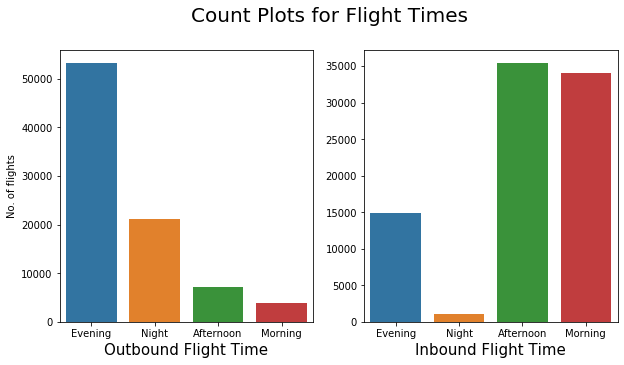

In [14]:
fig, ax = plt.subplots(figsize=(10,5), ncols=2, nrows=1)

plt.suptitle("Count Plots for Flight Times", y = 1, fontsize=20)
plt.ylabel('count flights')

plt.xlabel('')
plt.ylabel('Count of flights')

sns.countplot(x = 'Out_Time', data = train_set, ax=ax[0],order = train_set['Out_Time'].value_counts().index)
sns.countplot(x = 'In_Time', data = train_set,order = train_set['Out_Time'].value_counts().index)

ax[0].set_ylabel('No. of flights')
ax[0].set_xlabel('Outbound Flight Time',fontsize=15)
ax[1].set_ylabel('')
ax[1].set_xlabel('Inbound Flight Time',fontsize=15)



In [15]:
def get_as_date_format(date_as_str):
    return pd.to_datetime(date_as_str, format = '%Y/%m/%d')

out_date = []
for dep in train_set['Out_Departure']:
    out_date.append(dep[:10])

out_date = (pd.Series(out_date)).apply(get_as_date_format)

train_set.insert(3,'Out_Is_Weekend',list((out_date.dt.dayofweek// 5 == 1).astype(int)))
train_set.insert(3,'Out_Day_Of_Week', list(out_date.dt.day_name()))
train_set.insert(3,'Out_Day_Of_Month', list(out_date.dt.day))
train_set.insert(3,'Out_Month', list(out_date.dt.month))

In [16]:
in_date = []
for dep in train_set['In_Departure']:
    in_date.append(dep[:10])

in_date = (pd.Series(in_date)).apply(get_as_date_format)

train_set.insert(13,'In_Is_Weekend',list((in_date.dt.dayofweek// 5 == 1).astype(int)))
train_set.insert(13,'In_Day_Of_Week', list(in_date.dt.day_name()))
train_set.insert(13,'In_Day_Of_Month', list(in_date.dt.day))
train_set.insert(13,'In_Month', list(in_date.dt.month))


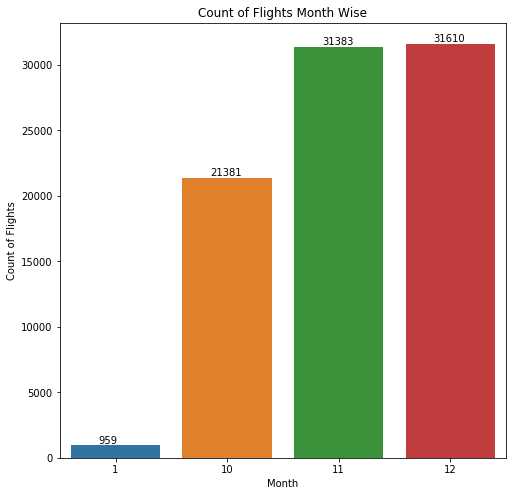

In [17]:
plt.figure(figsize = (8, 8))
plt.title('Count of Flights Month Wise')
ax=sns.countplot(x = 'Out_Month', data = train_set)
plt.xlabel('Month')
plt.ylabel('Count of Flights')
for p in ax.patches:
    ax.annotate(int(p.get_height()), (p.get_x()+0.25, p.get_height()+1), va='bottom',
                    color= 'black')

In [18]:
train_set.groupby(['Out_Month']).mean().loc[:, ['Price']].rename(columns={'Price': 'Price Mean'})

,Price Mean
Out_Month,
1,974.456090
10,1411.197396
11,827.108075
12,929.145171


In [19]:
train_set.groupby(['Out_Day_Of_Week']).mean().loc[:, ['Price']].rename(columns={'Price': 'Price Mean'})

,Price Mean
Out_Day_Of_Week,
Friday,1042.700043
Monday,972.465366
Saturday,1100.218328
Sunday,980.277329
Thursday,1097.297041
Tuesday,969.025647
Wednesday,930.313891


In [20]:
train_set.groupby(['Out_Is_Weekend']).mean().loc[:, ['Price']].rename(columns={'Price': 'Price Mean'})

,Price Mean
Out_Is_Weekend,
0,1002.658793
1,1039.310672


#### Get rid of unnecessary columns - due to feature extraction

In [21]:
train_set= train_set.drop(columns=['In_Departure','Out_Departure','In_Arrival','In_Arrival'])

Let's see the distribution of the prices over the airlines

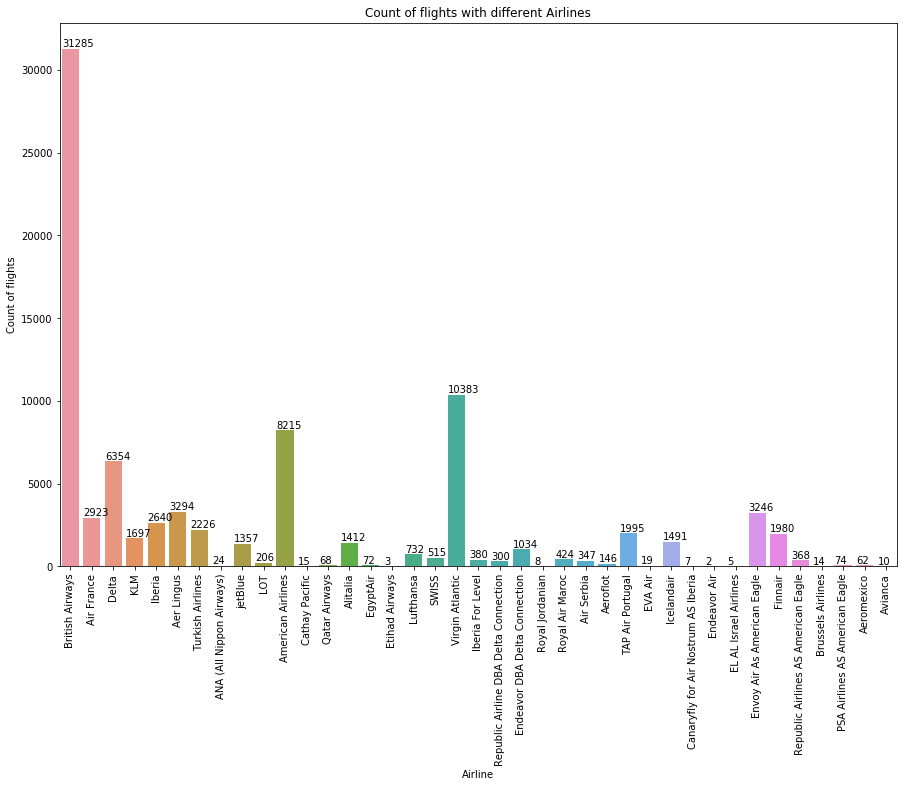

In [387]:
plt.figure(figsize = (15, 10))
plt.title('Count of flights with different Airlines')
ax=sns.countplot(x = 'Out_Airline', data =train_set)
plt.xlabel('Airline')
plt.ylabel('Count of flights')
plt.xticks(rotation = 90)

for p in ax.patches:
    ax.annotate(int(p.get_height()), (p.get_x(), p.get_height()+1), va='bottom',
                    color= 'black')

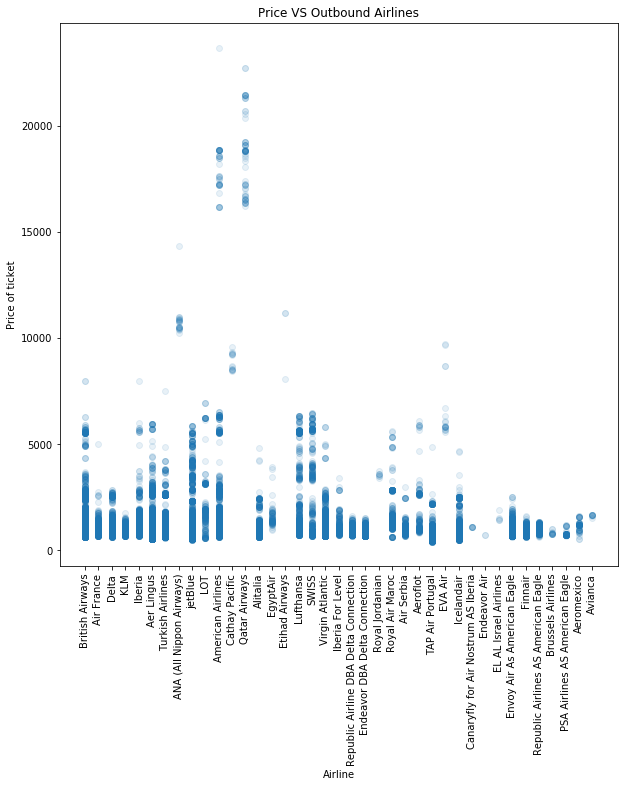

In [22]:
plt.figure(figsize = (10,10))
plt.title('Price VS Outbound Airlines')
plt.scatter(train_set['Out_Airline'], train_set['Price'],alpha=0.1)
plt.xticks(rotation = 90)
plt.xlabel('Airline')
plt.ylabel('Price of ticket')
plt.xticks(rotation = 90)
plt.show()

It would seem that on the outbound flights the only airlines that are very overpriced are Qatar Airways and American Airlines.

I plan to compare more features one with another, to see what can be discarded and what has more effect on the price

#### Encoding text into numbers
we'll start with the airlines 

In [24]:
from sklearn.preprocessing import OneHotEncoder
tr_set = train_set.drop(columns = ['Price','Out_ID','In_ID'])
cat_encoder = OneHotEncoder()
tr_set_1hot = cat_encoder.fit_transform(tr_set[['Out_Airline']])
tr_set_1hot.toarray()


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [25]:
cat_encoder.categories_


[array(['ANA (All Nippon Airways)', 'Aer Lingus', 'Aeroflot', 'Aeromexico',
        'Air France', 'Air Serbia', 'Alitalia', 'American Airlines',
        'Avianca', 'British Airways', 'Brussels Airlines',
        'Canaryfly for Air Nostrum AS Iberia', 'Cathay Pacific', 'Delta',
        'EL AL Israel Airlines', 'EVA Air', 'EgyptAir', 'Endeavor Air',
        'Endeavor DBA Delta Connection', 'Envoy Air As American Eagle',
        'Etihad Airways', 'Finnair', 'Iberia', 'Iberia For Level',
        'Icelandair', 'KLM', 'LOT', 'Lufthansa',
        'PSA Airlines AS American Eagle', 'Qatar Airways',
        'Republic Airline DBA Delta Connection',
        'Republic Airlines AS American Eagle', 'Royal Air Maroc',
        'Royal Jordanian', 'SWISS', 'TAP Air Portugal', 'Turkish Airlines',
        'Virgin Atlantic', 'jetBlue'], dtype=object)]

I might want to get rid of some of the data that isn't representitve, and I might also want to group the airlines that barely have any flights, though I'm still debating...
Also, I'll need to do some more encoding 

#### Feature Scaling 

need to do this...

## Comparing Different Models 

After all, this is a regression problem, so we'll be trying out some different models to help us predict the prices
I'm still not so sure exactly which models I'll be comparing, but I have some ideas.

In [26]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score

from math import sqrt

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import KFold


### Testing Final Model on Test Set

### My thoughts for the future and things to do 


In general, because I wasted so much time on working with amadeus's information, I didn't have so long to work on the information from Skyscanner.
I still need to finish preparing the data for the training models, decide which models would be the best, and to test the final model with the test set. Therefore, I have yet to analize whether my models are successful, or whether they overfit the data and likewise.
I think that overall I understand what needs to be done and more or less of how to do it.
I hope my final model is really representitve and works in real life.
Though I have a feeling that I'll need to update the data from time to time if I want it to continue to predict correctly...
